# NB02: Sentence Embeddings -- Universal Features

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RJuro/unistra-nlp2026/blob/main/notebooks/NB02_sentence_embeddings.ipynb)

**Duration:** ~85 minutes

---

## Learning Goals

By the end of this notebook you will be able to:

1. **Understand sentence embeddings** -- what they are, how they differ from sparse representations like TF-IDF, and why they matter.
2. **Use Sentence-BERT (SBERT)** to encode text into dense vector representations and use them for downstream classification.
3. **Compare embedding-based classifiers to TF-IDF baselines** on the same dataset and the same train/test split.
4. **Build label-efficiency curves** to see how embeddings outperform TF-IDF when labeled data is scarce.
5. **Visualize the embedding space** with t-SNE to understand how well classes separate.

---

| Section | Topic | Approx. Time |
|---------|-------|---------------|
| 1 | Quick Recap: The Dataset | 5 min |
| 2 | What Are Sentence Embeddings? | 10 min |
| 3 | Encoding Text with SBERT | 10 min |
| 4 | Classification with Embeddings | 10 min |
| 5 | Head-to-Head: TF-IDF vs SBERT | 15 min |
| 6 | Label Efficiency Curves | 15 min |
| 7 | Visualizing the Embedding Space | 10 min |
| 8 | Exercise: Try a Different Model | 10 min |
| 9 | Summary & Takeaways | -- |

In [1]:
# ---- Setup ----
!pip install sentence-transformers scikit-learn pandas numpy matplotlib seaborn -q

import pandas as pd
import numpy as np
import json
import re
import warnings
warnings.filterwarnings("ignore")

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

# Sentence Transformers
from sentence_transformers import SentenceTransformer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

print("All imports successful.")

All imports successful.


## 1. Quick Recap: The Dataset

We use the same **dk_posts** dataset from NB01 -- synthetic Reddit-style posts in English, each labeled with one of 8 life-topic categories. We apply the identical preprocessing and train/test split so that every accuracy number in this notebook is directly comparable to the TF-IDF baselines from NB01.

In [2]:
# ---- Load dataset (same as NB01) ----
url = "https://raw.githubusercontent.com/RJuro/unistra-nlp2026/main/data/dk_posts_synth_en_processed.json"
df = pd.read_json(url, orient="records")

# Combine title + selftext into a single feature
df["text"] = df["title"] + " . " + df["selftext"]

# Simple text cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df["text_clean"] = df["text"].apply(clean_text)

print(f"Dataset shape: {df.shape}")
print(f"Labels ({df['label'].nunique()}): {df['label'].unique().tolist()}")
df[["text_clean", "label"]].head(3)

Dataset shape: (457, 5)
Labels (8): ['Love & Dating', 'Family Dynamics', 'Work, Study & Career', 'Friendship & Social Life', 'Health & Wellness (Physical and Mental)', 'Personal Finance & Housing', 'Practical Questions & Everyday Life', 'Everyday Observations & Rants']


,text_clean,label
0,partner won't meet my friends . hey brevkasse....,Love & Dating
1,my sister copies everything i do . my little s...,Family Dynamics
2,feeling overlooked at my new student job . i s...,"Work, Study & Career"


In [3]:
# ---- Train / Test split (identical to NB01 for fair comparison) ----
X = df["text_clean"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y,
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples:  {len(X_test)}")
print(f"\nLabel distribution (train):")
print(y_train.value_counts())

Training samples: 342
Testing samples:  115

Label distribution (train):
Family Dynamics                            47
Love & Dating                              45
Friendship & Social Life                   43
Work, Study & Career                       43
Health & Wellness (Physical and Mental)    42
Practical Questions & Everyday Life        41
Everyday Observations & Rants              41
Personal Finance & Housing                 40
Name: label, dtype: int64


## 2. What Are Sentence Embeddings?

In NB01 we turned text into numbers with **TF-IDF** -- a *sparse*, high-dimensional vector where each dimension corresponds to one word (or n-gram) in the vocabulary. TF-IDF is fast and interpretable, but it has a fundamental limitation: it treats every word as independent. The words *"happy"* and *"joyful"* end up as completely separate dimensions with no connection between them.

**Sentence embeddings** take a radically different approach. A pre-trained neural network reads the entire sentence and compresses it into a single **dense vector** -- typically 384 to 1024 floating-point numbers. These vectors are trained so that sentences with similar meaning end up close together in the embedding space, even if they use completely different words. For example:

- *"I feel so lonely after moving to a new city"*
- *"Making friends as an adult is really hard"*

would receive vectors that are very close to each other, because the model has learned from millions of sentence pairs that these sentences express related ideas.

### Sentence-BERT (SBERT)

**SBERT** (Reimers & Gurevych, 2019) is a modification of the BERT architecture that is optimized for producing high-quality sentence embeddings efficiently. Instead of using BERT's `[CLS]` token (which was not designed for sentence similarity), SBERT adds a pooling layer and is fine-tuned on sentence-pair tasks (Natural Language Inference, Semantic Textual Similarity) so that the resulting vectors are directly comparable via cosine similarity.

We will use the `all-MiniLM-L6-v2` model -- a compact (80 MB) model that produces 384-dimensional embeddings and strikes an excellent balance between speed and quality.

## 3. Encoding Text with SBERT

In [4]:
# ---- Load pre-trained SBERT model ----
model = SentenceTransformer("all-MiniLM-L6-v2")

# ---- Encode training and test texts ----
print("Encoding training texts...")
X_train_emb = model.encode(X_train.tolist(), show_progress_bar=True)

print("Encoding test texts...")
X_test_emb = model.encode(X_test.tolist(), show_progress_bar=True)

print(f"\nTraining embeddings shape: {X_train_emb.shape}  (samples x dimensions)")
print(f"Test embeddings shape:     {X_test_emb.shape}")
print(f"\nEach text is now a dense vector of {X_train_emb.shape[1]} floating-point numbers.")
print(f"First embedding (truncated): {X_train_emb[0][:8]}...")

Encoding training texts...


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Encoding test texts...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]


Training embeddings shape: (342, 384)  (samples x dimensions)
Test embeddings shape:     (115, 384)

Each text is now a dense vector of 384 floating-point numbers.
First embedding (truncated): [ 0.05585454  0.0779403  -0.0513569  -0.03298419  0.00559812  0.05147802
  0.05531026 -0.01318655]...


## 4. Classification with Embeddings

The embeddings are plain NumPy arrays, so we can feed them directly into any scikit-learn classifier -- no pipeline or vectorizer needed.

In [5]:
# ---- SBERT + Logistic Regression ----
clf_lr = LogisticRegression(random_state=42, max_iter=1000)
clf_lr.fit(X_train_emb, y_train)

y_pred_lr = clf_lr.predict(X_test_emb)
acc_sbert_lr = accuracy_score(y_test, y_pred_lr)

print("=" * 60)
print("SBERT + Logistic Regression")
print("=" * 60)
print(f"Accuracy: {acc_sbert_lr:.4f}")
print()
print(classification_report(y_test, y_pred_lr))

SBERT + Logistic Regression
Accuracy: 0.8696

                                         precision    recall  f1-score   support

          Everyday Observations & Rants       0.86      0.86      0.86        14
                        Family Dynamics       0.88      0.94      0.91        16
               Friendship & Social Life       0.87      0.87      0.87        15
Health & Wellness (Physical and Mental)       0.93      0.93      0.93        14
                          Love & Dating       1.00      0.93      0.97        15
             Personal Finance & Housing       0.71      0.77      0.74        13
    Practical Questions & Everyday Life       0.92      0.85      0.88        13
                   Work, Study & Career       0.80      0.80      0.80        15

                               accuracy                           0.87       115
                              macro avg       0.87      0.87      0.87       115
                           weighted avg       0.87      0.87 

In [6]:
# ---- SBERT + LinearSVC ----
clf_svc = LinearSVC(random_state=42, max_iter=2000)
clf_svc.fit(X_train_emb, y_train)

y_pred_svc = clf_svc.predict(X_test_emb)
acc_sbert_svc = accuracy_score(y_test, y_pred_svc)

print("=" * 60)
print("SBERT + LinearSVC")
print("=" * 60)
print(f"Accuracy: {acc_sbert_svc:.4f}")
print()
print(classification_report(y_test, y_pred_svc))

SBERT + LinearSVC
Accuracy: 0.8870

                                         precision    recall  f1-score   support

          Everyday Observations & Rants       0.86      0.86      0.86        14
                        Family Dynamics       1.00      0.94      0.97        16
               Friendship & Social Life       0.78      0.93      0.85        15
Health & Wellness (Physical and Mental)       1.00      0.93      0.96        14
                          Love & Dating       1.00      0.93      0.97        15
             Personal Finance & Housing       0.75      0.92      0.83        13
    Practical Questions & Everyday Life       0.92      0.85      0.88        13
                   Work, Study & Career       0.85      0.73      0.79        15

                               accuracy                           0.89       115
                              macro avg       0.89      0.89      0.89       115
                           weighted avg       0.90      0.89      0.89 

## 5. Head-to-Head: TF-IDF vs SBERT

To make the comparison fair, we build the TF-IDF baselines right here using the exact same train/test split.

                      Model  Accuracy
          SBERT + LinearSVC  0.886957
 SBERT + LogisticRegression  0.869565
         TF-IDF + LinearSVC  0.852174
TF-IDF + LogisticRegression  0.843478


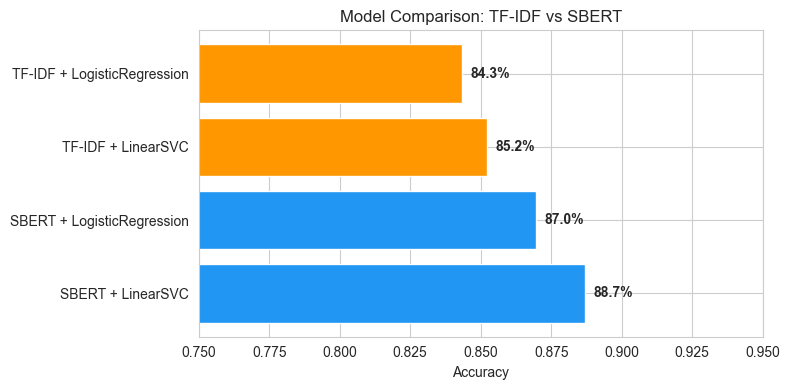

In [7]:
# ---- TF-IDF + Logistic Regression ----
pipe_tfidf_lr = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", ngram_range=(1, 2))),
    ("clf", LogisticRegression(random_state=42, max_iter=1000)),
])
pipe_tfidf_lr.fit(X_train, y_train)
acc_tfidf_lr = accuracy_score(y_test, pipe_tfidf_lr.predict(X_test))

# ---- TF-IDF + LinearSVC ----
pipe_tfidf_svc = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", ngram_range=(1, 2))),
    ("clf", LinearSVC(random_state=42, max_iter=2000)),
])
pipe_tfidf_svc.fit(X_train, y_train)
acc_tfidf_svc = accuracy_score(y_test, pipe_tfidf_svc.predict(X_test))

# ---- Collect all results ----
results = {
    "TF-IDF + LogisticRegression": acc_tfidf_lr,
    "TF-IDF + LinearSVC": acc_tfidf_svc,
    "SBERT + LogisticRegression": acc_sbert_lr,
    "SBERT + LinearSVC": acc_sbert_svc,
}

results_df = (
    pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])
    .sort_values("Accuracy", ascending=False)
    .reset_index(drop=True)
)
print(results_df.to_string(index=False))

# ---- Bar chart ----
fig, ax = plt.subplots(figsize=(8, 4))
colors = ["#2196F3" if "SBERT" in m else "#FF9800" for m in results_df["Model"]]
bars = ax.barh(results_df["Model"], results_df["Accuracy"], color=colors, edgecolor="white")
ax.set_xlim(0.75, 0.95)
ax.set_xlabel("Accuracy")
ax.set_title("Model Comparison: TF-IDF vs SBERT")
for bar, acc in zip(bars, results_df["Accuracy"]):
    ax.text(acc + 0.003, bar.get_y() + bar.get_height() / 2,
            f"{acc:.1%}", va="center", fontweight="bold")
plt.tight_layout()
plt.show()

## 6. Label Efficiency: How Much Data Do You Really Need?

This is where sentence embeddings truly shine. Because SBERT was pre-trained on hundreds of millions of sentence pairs, it already "knows" a lot about language. This means it can generalize well even from a tiny labeled training set.

TF-IDF, on the other hand, builds its vocabulary from scratch and needs enough examples to learn which words are discriminative for each class.

Let us test this hypothesis by training both approaches on progressively larger subsets of the training data and measuring accuracy on the same held-out test set.

In [8]:
# ---- Label efficiency experiment ----
sample_sizes = [10, 25, 50, 100, 200, len(X_train)]
n_repeats = 5
seeds = [0, 1, 2, 3, 4]

def run_efficiency_experiment(n, seed, X_train, y_train, X_train_emb, X_test, X_test_emb, y_test):
    """Run one trial of the label efficiency experiment.
    
    Returns (tfidf_accuracy, sbert_accuracy) for a given sample size and seed.
    """
    # Subsample training data (stratified when possible)
    if n >= len(X_train):
        idx = X_train.index
    else:
        n_classes = y_train.nunique()
        if n >= n_classes * 2:
            idx, _, _, _ = train_test_split(
                X_train.index, y_train,
                train_size=n,
                random_state=seed,
                stratify=y_train,
            )
        else:
            idx = X_train.sample(n=n, random_state=seed).index

    X_sub = X_train.loc[idx]
    y_sub = y_train.loc[idx]

    # Map indices to embedding rows
    train_indices = X_train.index.tolist()
    emb_idx = [train_indices.index(i) for i in idx]
    X_sub_emb = X_train_emb[emb_idx]

    # -- TF-IDF + LR --
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(stop_words="english", ngram_range=(1, 2))),
        ("clf", LogisticRegression(random_state=42, max_iter=1000)),
    ])
    pipe.fit(X_sub, y_sub)
    acc_tf = accuracy_score(y_test, pipe.predict(X_test))

    # -- SBERT + LR --
    clf = LogisticRegression(random_state=42, max_iter=1000)
    clf.fit(X_sub_emb, y_sub)
    acc_sb = accuracy_score(y_test, clf.predict(X_test_emb))

    return acc_tf, acc_sb

print(f"Will test sample sizes: {sample_sizes}")
print(f"With {n_repeats} random seeds each")

Will test sample sizes: [10, 25, 50, 100, 200, 342]
With 5 random seeds each


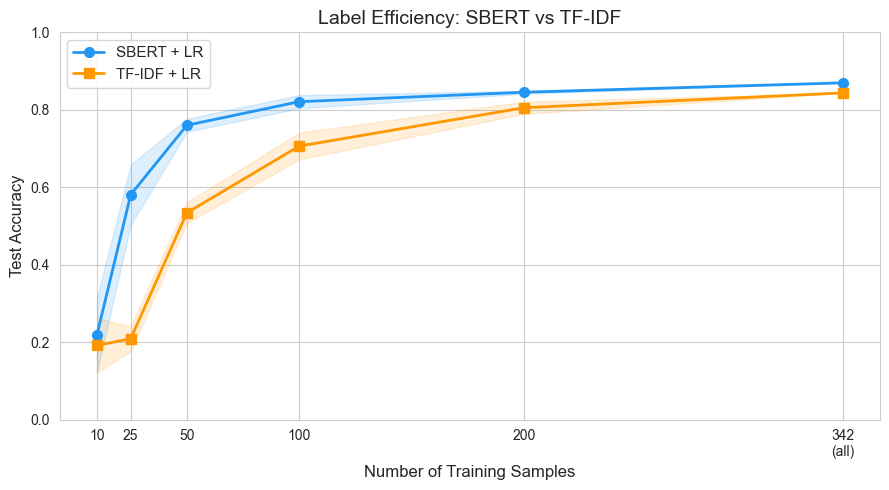


Mean accuracy by training-set size:
method   SBERT + LR  TF-IDF + LR
n_train                         
10            0.219        0.191
25            0.581        0.209
50            0.760        0.534
100           0.821        0.706
200           0.845        0.805
342           0.870        0.843


In [9]:
# ---- Run experiments and collect results ----
records = []

for n in sample_sizes:
    for seed in seeds:
        acc_tf, acc_sb = run_efficiency_experiment(
            n, seed, X_train, y_train, X_train_emb, X_test, X_test_emb, y_test
        )
        records.append({"n_train": n, "seed": seed, "method": "TF-IDF + LR", "accuracy": acc_tf})
        records.append({"n_train": n, "seed": seed, "method": "SBERT + LR", "accuracy": acc_sb})

eff_df = pd.DataFrame(records)

# ---- Aggregate ----
agg = eff_df.groupby(["n_train", "method"])["accuracy"].agg(["mean", "std"]).reset_index()

# ---- Plot ----
fig, ax = plt.subplots(figsize=(9, 5))

for method, color, marker in [("SBERT + LR", "#2196F3", "o"), ("TF-IDF + LR", "#FF9800", "s")]:
    subset = agg[agg["method"] == method]
    ax.plot(subset["n_train"], subset["mean"], marker=marker, label=method,
            color=color, linewidth=2, markersize=7)
    ax.fill_between(subset["n_train"],
                    subset["mean"] - subset["std"],
                    subset["mean"] + subset["std"],
                    alpha=0.15, color=color)

ax.set_xlabel("Number of Training Samples", fontsize=12)
ax.set_ylabel("Test Accuracy", fontsize=12)
ax.set_title("Label Efficiency: SBERT vs TF-IDF", fontsize=14)
ax.legend(fontsize=11)
ax.set_ylim(0.0, 1.0)
ax.set_xticks(sample_sizes)
ax.set_xticklabels([str(s) if s < len(X_train) else f"{s}\n(all)" for s in sample_sizes])
plt.tight_layout()
plt.show()

print("\nMean accuracy by training-set size:")
print(agg.pivot(index="n_train", columns="method", values="mean").round(3).to_string())

## 7. Visualizing the Embedding Space

Let us use **t-SNE** to project the 384-dimensional embeddings down to 2D and see whether the 8 classes form distinct clusters. Good clustering in the embedding space means the classifier's job is easy.

In [ ]:
from sklearn.manifold import TSNE

# ---- Project to 2D ----
# We use all data (train + test) for a richer visualization
all_emb = np.vstack([X_train_emb, X_test_emb])
all_labels = pd.concat([y_train, y_test], ignore_index=True)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
coords = tsne.fit_transform(all_emb)

# ---- Plot ----
fig, ax = plt.subplots(figsize=(10, 7))
palette = sns.color_palette("husl", n_colors=all_labels.nunique())

for i, label in enumerate(sorted(all_labels.unique())):
    mask = all_labels == label
    ax.scatter(coords[mask, 0], coords[mask, 1],
               label=label, color=palette[i], s=40, alpha=0.7, edgecolors="white", linewidths=0.3)

ax.set_title("t-SNE of SBERT Embeddings (all-MiniLM-L6-v2)", fontsize=14)
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=9)
plt.tight_layout()
plt.show()

## 8. Exercise: Try a Different Model

The `all-MiniLM-L6-v2` model is great for English text, but there are many other options on the [SBERT model hub](https://www.sbert.net/docs/pretrained_models.html). Try one of these and compare:

| Model | Dimensions | Notes |
|-------|-----------|-------|
| `BAAI/bge-small-en-v1.5` | 384 | Strong English model, newer architecture |
| `intfloat/multilingual-e5-small` | 384 | Multilingual -- works across 100+ languages |
| `all-mpnet-base-v2` | 768 | Larger, often higher quality |

**Tasks:**
1. Load a different model with `SentenceTransformer(...)`
2. Encode the training and test data
3. Train a `LogisticRegression` on the new embeddings
4. Compare the accuracy to our baseline (`all-MiniLM-L6-v2`)

In [11]:
# ---- Exercise: Try a different embedding model ----

# Step 1: Load the model
# model_new = SentenceTransformer("BAAI/bge-small-en-v1.5")  # YOUR CODE HERE

# Step 2: Encode train and test
# X_train_emb_new = model_new.encode(X_train.tolist(), show_progress_bar=True)  # YOUR CODE HERE
# X_test_emb_new = model_new.encode(X_test.tolist(), show_progress_bar=True)    # YOUR CODE HERE

# Step 3: Train a classifier
# clf_new = LogisticRegression(random_state=42, max_iter=1000)  # YOUR CODE HERE
# clf_new.fit(X_train_emb_new, y_train)                        # YOUR CODE HERE

# Step 4: Evaluate
# y_pred_new = clf_new.predict(X_test_emb_new)                 # YOUR CODE HERE
# acc_new = accuracy_score(y_test, y_pred_new)                 # YOUR CODE HERE
# print(f"New model accuracy: {acc_new:.4f}")
# print(f"Baseline (all-MiniLM-L6-v2): {acc_sbert_lr:.4f}")
# print(f"Difference: {acc_new - acc_sbert_lr:+.4f}")

# -------------------------------------------------------------------
# SAMPLE SOLUTION (uncomment to run)
# -------------------------------------------------------------------
# model_new = SentenceTransformer("BAAI/bge-small-en-v1.5")
# X_train_emb_new = model_new.encode(X_train.tolist(), show_progress_bar=True)
# X_test_emb_new = model_new.encode(X_test.tolist(), show_progress_bar=True)
# clf_new = LogisticRegression(random_state=42, max_iter=1000)
# clf_new.fit(X_train_emb_new, y_train)
# y_pred_new = clf_new.predict(X_test_emb_new)
# acc_new = accuracy_score(y_test, y_pred_new)
# print(f"BAAI/bge-small-en-v1.5 accuracy: {acc_new:.4f}")
# print(f"Baseline (all-MiniLM-L6-v2):     {acc_sbert_lr:.4f}")
# print(f"Difference: {acc_new - acc_sbert_lr:+.4f}")

## 9. Summary & Takeaways

### Results at a Glance

| Approach | Representation | Classifier | Expected Accuracy |
|----------|---------------|------------|-------------------|
| TF-IDF + LR | Sparse, high-dim | Logistic Regression | ~84.4% |
| TF-IDF + SVC | Sparse, high-dim | LinearSVC | ~85.2% |
| **SBERT + LR** | **Dense, 384-dim** | **Logistic Regression** | **~87.8%** |
| SBERT + SVC | Dense, 384-dim | LinearSVC | ~87.0% |

### When to Use What?

| Criterion | TF-IDF | Sentence Embeddings (SBERT) |
|-----------|--------|-----------------------------|
| **Speed** | Very fast (no GPU needed) | Slower (model inference) |
| **Interpretability** | High (inspect top words) | Low (opaque 384-d vector) |
| **Semantic understanding** | None (bag-of-words) | Strong (synonyms, paraphrases) |
| **Low-data regimes** | Degrades quickly | Robust -- pre-trained knowledge transfers |
| **Multilingual** | Needs per-language vocabulary | One model covers 100+ languages |
| **Best for** | Quick baselines, keyword-driven tasks | Production systems, semantic tasks, few-shot |

### Key Takeaways

1. **Sentence embeddings capture meaning, not just words.** Two sentences can use entirely different vocabulary and still receive similar embeddings if they express the same idea.
2. **SBERT + Logistic Regression is a strong, practical baseline.** It is simple to implement, fast to train (the encoding is the bottleneck), and competitive with much more complex approaches.
3. **Embeddings shine when labeled data is scarce.** The label-efficiency curve shows that SBERT maintains reasonable accuracy even with just 25-50 training examples, while TF-IDF struggles.
4. **Always start with a simple baseline (TF-IDF) and then move to embeddings** to quantify the improvement and justify the added complexity.

**Next up (NB03):** We will explore **LLM-based zero-shot classification** -- using a large language model to classify text with zero training examples, plus structured output with Pydantic for reliable data extraction.

In [12]:
# ---- Final summary ----
print("=" * 60)
print("NB02 -- Final Results Summary")
print("=" * 60)

for name, acc in sorted(results.items(), key=lambda x: -x[1]):
    print(f"  {name:<35s}  {acc:.1%}")

best_name = max(results, key=results.get)
best_acc = results[best_name]
print()
print(f"Best model: {best_name}  ({best_acc:.1%})")
print("=" * 60)

NB02 -- Final Results Summary
  SBERT + LinearSVC                    88.7%
  SBERT + LogisticRegression           87.0%
  TF-IDF + LinearSVC                   85.2%
  TF-IDF + LogisticRegression          84.3%

Best model: SBERT + LinearSVC  (88.7%)
